# SAÉ Data Mining
## Étude de cas : Commentaires Amazon

- Étudiants : *Paul PONCET, Kylian ROUVEURE*

Nom de groupe Kaggle : *l'huricane*

## Librairies

In [11]:
!pip install -q unidecode

In [12]:
!pip install stop-words

In [13]:
import pandas as pd
import numpy as np
import re
import unidecode
import spacy.cli

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.decomposition import  PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [14]:
spacy.cli.download("fr_core_news_sm");

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Nettoyage des données

In [ ]:
nlp = spacy.load("fr_core_news_sm") # Chargement du modèle spaCy pour le français

# Fonction pour le prétraitement et la lemmatisation
def preprocess_lemmatise(text):
    # Suppression des caractères non alphabétiques et conversion en minuscules
    text = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', text).lower()
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # Lemmatisation
    return ' '.join([token.lemma_ for token in nlp(unidecode.unidecode(text))])

# Fonction pour traiter et exporter un fichier CSV
def process_and_export_csv(input_file, output_file, columns):
    data = pd.read_csv(input_file) # Chargement des données
    df = pd.DataFrame(data, columns=columns) # Création du DataFrame
    df['avis_preprocessed'] = df['avis'].apply(preprocess_lemmatise) # Application du prétraitement
    df['id'] = range(0, len(df)) # Numérotation séquentielle de la colonne 'id'

    export_columns = ['id', 'avis_preprocessed'] # Détermination des colonnes à exporter
    if 'polarité' in columns:
        export_columns.append('polarité')

    header_columns = ['id', 'avis'] # Détermination des colonnes à exporter
    if 'polarité' in columns:
        header_columns.append('polarité')

    df[export_columns].to_csv(output_file, index=False, header=header_columns)# Exportation du fichier CSV

    print(f"Exportation de {output_file} terminée.")

process_and_export_csv('sae_train.csv', 'sae_train_lemmatise.csv', ['id', 'avis', 'polarité']) # Traitement et exportation du premier fichier CSV
process_and_export_csv('sae_test.csv', 'sae_test_lemmatise.csv', ['id', 'avis']) # Traitement et exportation du deuxième fichier CSV


Explication de nos pré-traitements :

Pour le pré-traitement de nos données, notre but est de normaliser les données afin de faciliter le traitement que nous allons réaliser derrière.

Afin de réaliser cette normalisation, nous avons procédé à plusieurs étapes :
- re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', text), nous permets de supprimer les caractères qui ne sont pas alphabétiques, pour être remplacés par un espace. Cela supprime aussi les caractères accentués.
- ' '.join([word for word in text.split() if len(word) > 1]), nous permets de diviser le texte en mots, et ne garder que les mots ayant une longueur supérieure à 1 caractère.

Pour la suite, nous avons opté pour la lemmatisation. Cela permet de récupérer le lemme du mot, c'est-à-dire la forme du mot tel qu'elle peut apparaitre dans le dictionnaire. Nous avions le choix avec la racinisation. Cependant, cette dernière permet d'avoir un mot plus simple que l'original, mais qui n'est pas forcément un mot réel. De ce fait il allait être compliqué de réaliser un bon traitement avec des mots qui aurait été quelque peu différent que ce qu'on aura avec une lemmisation.

## Traitement des données (Temps env. 1min30)

In [15]:
def preprocess(text):
  text = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', text).lower()
  text = ' '.join([word for word in text.split() if len(word) > 1])
  return unidecode.unidecode(text)

def make_grid_search(df_train, splits) :
  stratified_kfold = StratifiedKFold(n_splits=splits)
  grid_search = GridSearchCV(pipeline, parameters, cv=stratified_kfold, n_jobs=-1,
          scoring={'accuracy': make_scorer(accuracy_score),
                  'precision': make_scorer(precision_score, average='weighted'),
                  'recall': make_scorer(recall_score, average='weighted'),
                  'f1_score': make_scorer(f1_score, average='weighted')},
          refit='f1_score')
  # Affichage des meilleurs paramètres et score
  return grid_search.fit(df_train['avis'], df_train['polarité'])

def predict_polarity_and_score(train_data, test_data):
    grid_search = make_grid_search(train_data, 7) # 7 = 0.85679
    predictions = grid_search.predict(test_data)
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    return predictions, best_score, best_params

In [16]:
# Configuration du pipeline avec notre vectorisation du texte et la regression Logistique pour la prédiction des classes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('logistic', LogisticRegression())
])

# Liste de tout les paramètres qu'on a testés (2h de prédictions)
'''parameters = {
    'tfidf__max_df': [0.4, 0.5, 0.55, 0.57, 0.6],
    'tfidf__min_df': [1, 2, 3, 4, 5],
    'tfidf__max_features': [None, 10, 50, 100, 500, 5000],
    'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'logistic__C': [10, 20, 50],
    'logistic__penalty': ['l1', 'l2', 'ElasticNet'],
    'logistic__solver': ['saga', 'liblinear', 'lbfgs']
}'''

# Définition des meilleurs paramètres pour GridSearch
parameters = {
    'tfidf__max_df': [0.57],
    'tfidf__min_df': [1],
    'tfidf__max_features': [None],
    'tfidf__ngram_range': [(1, 3)],
    'logistic__C': [10],
    'logistic__penalty': ['l2'],
    'logistic__solver': ['saga'],
}

# Charger les données
df_train = pd.read_csv('sae_train_lemmatise.csv')
df_test = pd.read_csv('sae_test_lemmatise.csv')

# Prétraitement des avis
df_train['avis'] = df_train['avis'].apply(preprocess)
df_test['avis'] = df_test['avis'].apply(preprocess)

# Utiliser la fonction de prédiction et obtenir le score
df_test['predicted_polarity'], model_score, best_params = predict_polarity_and_score(df_train, df_test['avis'])

# score (kaggle 0.859, ce notebook 0.8567)
print("Meilleur score du modèle:", model_score)
print("Meilleurs paramètres:", best_params)

Meilleur score du modèle: 0.8567744980776241
Meilleurs paramètres: {'logistic__C': 10, 'logistic__penalty': 'l2', 'logistic__solver': 'saga', 'tfidf__max_df': 0.57, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3)}


Classifieur :

Explication du classifieurs :

Nous avons utilisé Pipeline qui va permettre de réaliser 2 traitements :

- TfidfVectorizer(stop_words=final_stopwords_list), va permettre de calculer la fréquence d'apparition des termes comme avec CountVectorizer, cependant il va prendre en compte et l'importance du mot dans un document, mais aussi dans l'ensemble des documents. Si un mot apparait fréquement dans un avis, mais assez rarement dans l'ensemble des avis, il aura un poids plus élevé.


- Pour ce qui est du classifieur, nous avons testé la régression logistique et le classifieur bayésien. Nous avons constaté qu'avec les paramètres par défaut, le résultat le plus élevé nous était données par la régression logistique. Nous avons donc décidé de partir sur ce classifieur. Par la suite nous avons réalisé une liste d'hyperparamètre du classifieur. Le code va faire toutes les combinaisons possibles et nous sortir les paramètres amenant au meilleur score.

## Exportation des résultats

In [ ]:
df_test[['id', 'predicted_polarity']].to_csv('sae_prediction.csv', index=False, header=['id', 'polarity'])

## Analyses

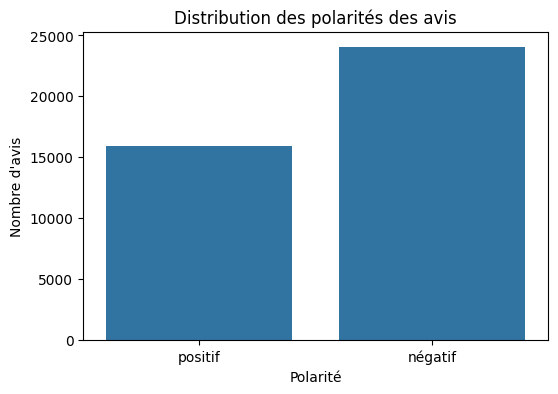

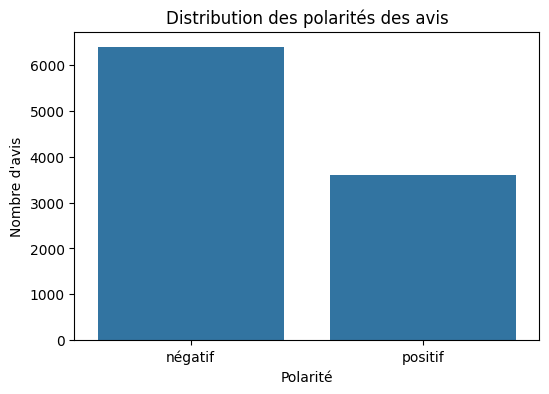

In [ ]:
# Distributions des polarités des données d'entrainements
plt.figure(figsize=(6,4))
sns.countplot(x='polarité', data=df_train)
plt.title("Distribution des polarités de la base d'entrainement")
plt.xlabel('Polarité')
plt.ylabel('Nombre d\'avis')
plt.show()

# Distributions des polarités des nouveaux commentaires
plt.figure(figsize=(6,4))
sns.countplot(x='predicted_polarity', data=df_test)
plt.title('Distribution des polarités des nouveaux commentaires')
plt.xlabel('Polarité')
plt.ylabel('Nombre d\'avis')
plt.show()

Sur ces graphiques, nous représentons la distribution des polarités des avis pour les données d'entrainement et les données test. On peut voir que dans les 2 cas, la répartition est assez similaire, avec une assz grande majorité d'avis négatif.

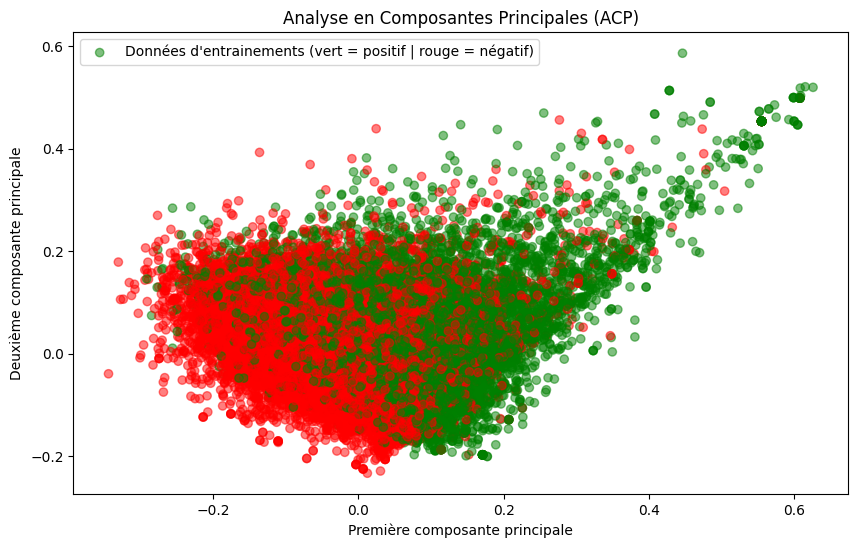

In [ ]:
# Vectorisation des données en ACP
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(df_train['avis'])
X_test = vectorizer.transform(df_test['avis'])

# Création de l'ACP
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

# Préparation des couleurs selon la polarité
colors_train = ['green' if p == 'positif' else 'red' for p in df_train['polarité']]
colors_test = ['blue' if p == 'positif' else 'yellow' for p in df_test['predicted_polarity']]

# ACP Données d'entrainements
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], color=colors_train, alpha=0.5, label="Données d'entrainements (vert = positif | rouge = négatif)")
plt.title('Analyse en Composantes Principales (ACP)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.show()

Ici nous avons réalisé une ACP avec les données d'entrainements. On peut assez aisément distinguer les avis positif et les avis négatif. En rouge, les avis négatif se rerouvent généralement en bas à droite de l'acp, contrairement au vert, les avis positif, qui se concentre plus généralement au centre et dans une moindre mesure, en haut à gauche.

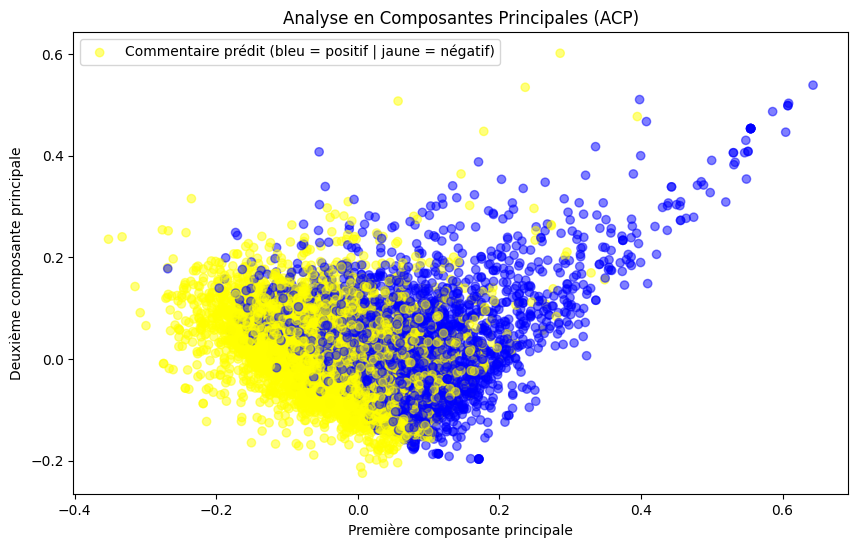

In [ ]:
# ACP Nouveaux commentaires
plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], color=colors_test, alpha=0.5, label='Commentaire prédit (bleu = positif | jaune = négatif)')
plt.title('Analyse en Composantes Principales (ACP)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.show()

Nous avons réalisé la même ACP que précédement et de la même manière, nous arrivons à distinguer le groupe des avis positif en bleu, assez centré, et les avis négatif en jaune, qui se trouvent surtout sur la partie gauche de l'ACP.

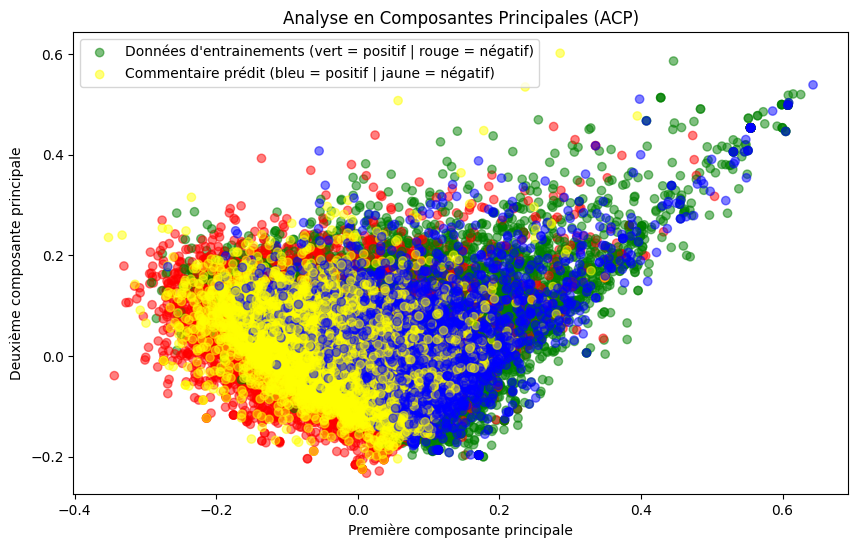

In [ ]:
# Tracé des graphiques ACP
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], color=colors_train, alpha=0.5, label="Données d'entrainements (vert = positif | rouge = négatif)")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], color=colors_test, alpha=0.5, label='Commentaire prédit (bleu = positif | jaune = négatif)')
plt.title('Analyse en Composantes Principales (ACP)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.show()

Nous pouvons voir avec la superposition des 2 graphiques précédent, que la concentration des avis positif et négatif sont assez similaire pour les deux sources de données.

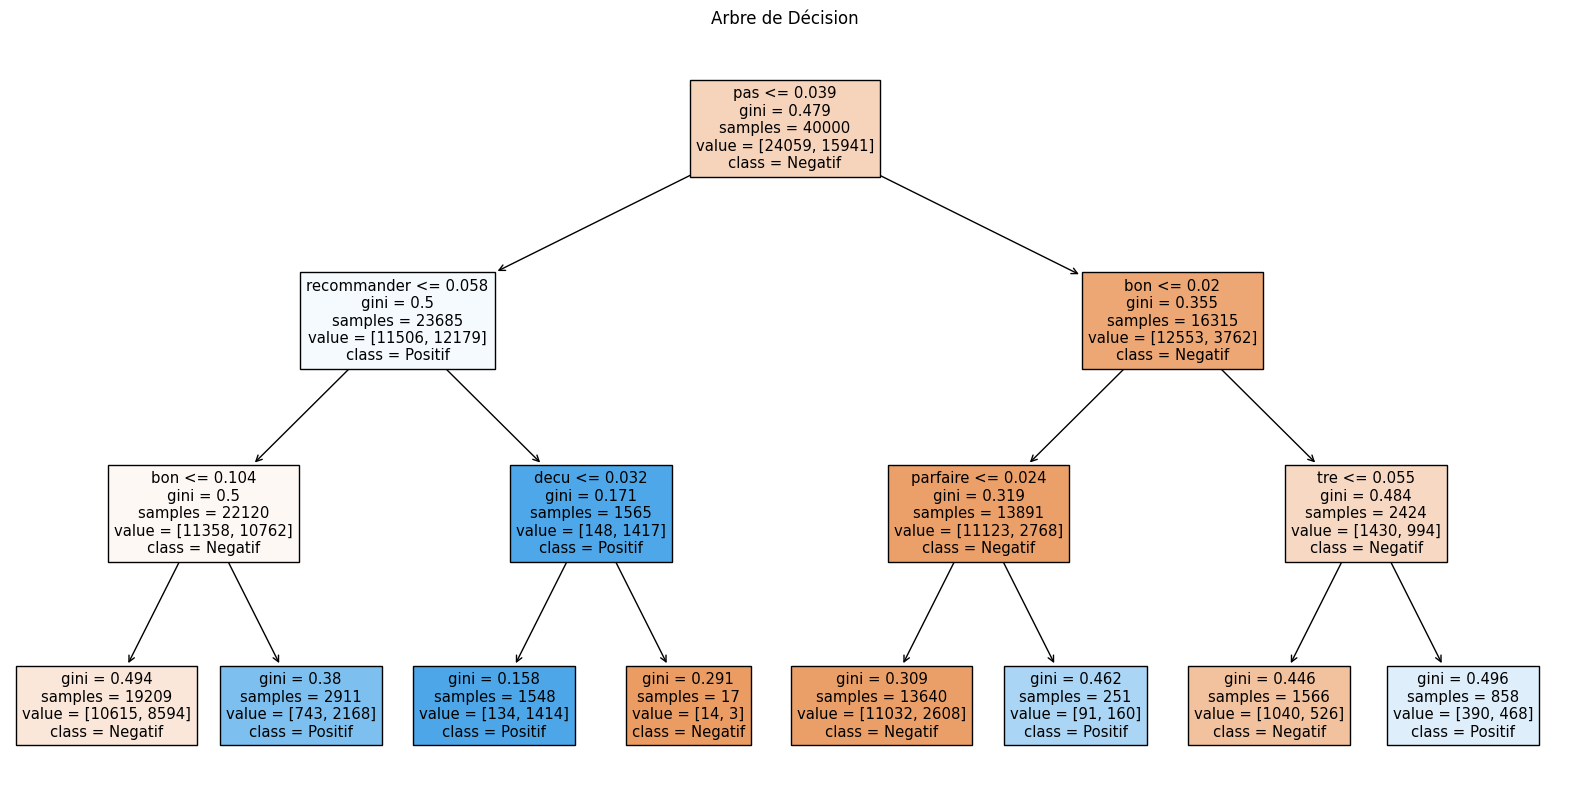

In [ ]:
# Entraînement d'un modèle d'arbre de décision pour la visualisation
dt_model = DecisionTreeClassifier(max_depth=3)  # Limitez la profondeur pour une meilleure lisibilité
dt_model.fit(X_train, df_train['polarité'])

# Tracé de l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=vectorizer.get_feature_names_out(), class_names=['Negatif', 'Positif'])
plt.title('Arbre de Décision')
plt.show()

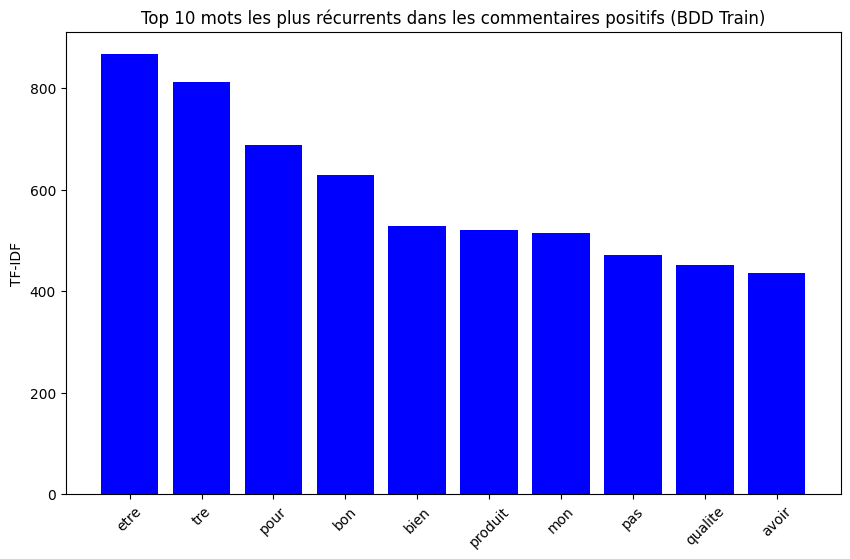

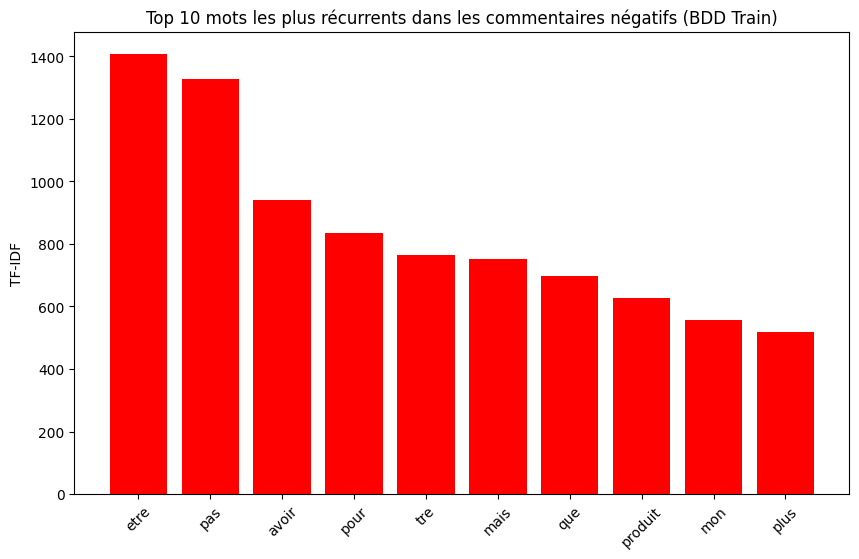

In [17]:
df_positif = df_train[df_train['polarité'] == 'positif']['avis']
df_negatif = df_train[df_train['polarité'] == 'négatif']['avis']

def mots_plus_frequents(textes):
  vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b\w\w\w+\b')  # Modifier ici
  tfidf_matrix = vectorizer.fit_transform(textes)
  mots = vectorizer.get_feature_names_out()
  sommes = np.sum(tfidf_matrix, axis=0)
  data = np.squeeze(np.asarray(sommes))
  mots_freq = dict(zip(mots, data))
  # Trier les mots par fréquence et sélectionner les 10 premiers
  mots_freq = dict(sorted(mots_freq.items(), key=lambda item: item[1], reverse=True)[:10])
  return mots_freq

# Fonction pour tracer les graphiques
def tracer_graphique(mots_freq, titre, barcolor):
    mots = list(mots_freq.keys())
    freqs = list(mots_freq.values())
    plt.figure(figsize=(10, 6))
    plt.bar(mots, freqs, color=barcolor)
    plt.title(titre)
    plt.xticks(rotation=45)
    plt.ylabel('TF-IDF')
    plt.show()

# Extraction et affichage pour les commentaires positifs
mots_freq_positif = mots_plus_frequents(df_positif)
tracer_graphique(mots_freq_positif, 'Top 10 mots les plus récurrents dans les commentaires positifs (BDD Train)', 'blue')

# Extraction et affichage pour les commentaires négatifs
mots_freq_negatif = mots_plus_frequents(df_negatif)
tracer_graphique(mots_freq_negatif, 'Top 10 mots les plus récurrents dans les commentaires négatifs (BDD Train)', 'red')